## Introduction

The motivation for this project resulted from the extreme weather experienced in the UK during the summer of 2022. The country saw unprecented daily temperatures exceeding 40°C, leading to wildfires, hosepipe bans and an increase in cases of heatstroke and dehydration especially in more vulnerable citizens. For myself it was quite a shocking experience, mainly because of the wider context of global climate change. Events like these are unfortunately the tip of the iceberg and cannot compare to some of the widespread climate damage already being experienced in less-fortunate parts of the world.

I gained some further insights and inspiration by reading Bill Gates' new book, 'How to Avoid a Climate Disaster', making me realise that in order to tackle this challenge, a large amount of thorough and strategic planning needs to be undertaken by governing bodies around the world. The problem of mitigating and adapting to climate change will be incredibly complex. In light of this, I thought it would be useful to demonstrate how data science and machine learning could be used to add value in this area and provide solutions.

The focus of this project is analysing the pattern of water security in the UK. In the fifth dataset listed in the next section, the Environmental Information Data Centre provides a list of what they describe as "DWS (drought and water security) events", during which parts of the UK could not supply enough water to meet demand. These events are not purely natural hazards; they are also caused by changes in water consumption behaviour. The main objectives of this project are to:
1. Explore the historical pattern of DWS events, as well as the patterns in both the demand and supply-side factors at a national scale.
2. Investigate the viability of various statistical models to predict these events based on the demand and supply-side factors.
3. Use these statistical models to draw conclusions about the interaction between these factors and the probability of water insecurity of the UK.

I am also planning to follow this project with another which involves developing more sophisticated deep learning models to detect wildfires in digital images, see the [GitHub repository](https://github.com/james-hughes1/wildfire-detection).

## Importing the Data

Our study involves seven datasets. Three relate to socio-economic 'demand-side' factors, three relate to climate, and one is an account of the DWS events in recent history.

More information can be found about the data sources at these links:
1. Crop Yields from DEFRA http://www.defra.gov.uk/statistics/files/defra-stats-foodfarm-food-cereals-cerealoilseed-dataset-111222.xls
2. Industrial Production Index UK FRED Economic Data https://fred.stlouisfed.org/series/IPIUKM
3. Population Estimates ONS https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/adhocs/004356ukpopulationestimates1851to2014
4. Weather Records Met Office https://www.metoffice.gov.uk/research/climate/maps-and-data/uk-and-regional-series
5. List of droughts from EICD (specifically 'DWS events') https://reshare.ukdataservice.ac.uk/853673/

In [1]:
import pandas as pd

In [2]:
cropdata = pd.read_excel('defra-stats-foodfarm-food-cereals-cerealoilseed-dataset-111222.xls', sheet_name=1,
                         skiprows=8, usecols=[0,1], names=['Year', 'Wheat Yield'], skipfooter=4).astype({'Wheat Yield': float})
cropdata

,Year,Wheat Yield
0,1885,2.360000
1,1886,2.030000
2,1887,2.410000
3,1888,2.110000
4,1889,2.250000
...,...,...
122,2007,7.234263
123,2008,8.281403
124,2009,7.927665
125,2010,7.700000


In [3]:
ipidata = pd.read_excel('IPIUKM.xls', sheet_name=0,
                        skiprows=11, header=None, names=['Date', 'Industry Output'], )
ipidata

,Date,Industry Output
0,1920-01-01,29.27
1,1920-02-01,29.27
2,1920-03-01,28.69
3,1920-04-01,28.74
4,1920-05-01,29.54
...,...,...
1160,2016-09-01,103.90
1161,2016-10-01,102.70
1162,2016-11-01,105.10
1163,2016-12-01,106.00


In [4]:
popdata = pd.read_excel('ukpopulationestimates18512014.xls', sheet_name=1,
                        skiprows=6, header=None, usecols=[0,1], names=['Year', 'Population'],
                        skipfooter=14)
popdata

,Year,Population
0,1871,31484700
1,1872,31874200
2,1873,32177600
3,1874,32501500
4,1875,32838800
...,...,...
139,2010,62759456
140,2011,63285145
141,2012,63705030
142,2013,64105654


In [5]:
cols = ['year','jan','feb','mar','apr','may','jun',
        'jul','aug','sep','oct','nov','dec','win',
        'spr','sum','aut','ann']

In [6]:
with open('UK Mean Temp.txt') as f:
    tempdatatxt = f.read().split()[73:-10]

tempdata = pd.DataFrame([tempdatatxt[18*i:18*(i+1)] for i in range(137)],
                        columns=cols, dtype=float).astype({'year':int})
tempdata

,year,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,win,spr,sum,aut,ann
0,1885,2.0,4.2,3.5,6.6,7.6,12.3,14.5,12.4,10.9,6.2,4.8,3.0,3.14,5.92,13.09,7.28,7.36
1,1886,1.1,0.8,2.9,6.3,8.8,11.9,14.2,14.1,12.0,9.9,5.7,1.2,1.68,6.01,13.42,9.20,7.45
2,1887,2.1,3.5,3.3,5.4,8.7,14.3,15.6,14.0,10.6,6.4,3.9,2.1,2.23,5.80,14.61,6.97,7.51
3,1888,2.8,1.1,2.1,5.3,9.2,11.8,12.3,12.8,11.2,7.6,6.5,4.3,2.03,5.56,12.31,8.43,7.28
4,1889,3.0,2.2,3.8,6.0,11.4,14.0,13.6,13.4,11.5,7.6,6.1,3.1,3.21,7.10,13.66,8.41,8.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,2017,3.8,5.2,7.3,8.0,12.1,14.4,15.1,14.5,12.5,11.2,5.7,4.1,4.97,9.12,14.70,9.84,9.53
133,2018,4.0,2.3,3.8,8.4,12.0,14.8,17.2,15.2,12.4,9.5,7.3,5.8,3.52,8.08,15.76,9.73,9.45
134,2019,3.4,6.0,6.8,8.4,10.0,13.2,16.4,15.8,13.1,8.9,5.3,5.1,5.05,8.38,15.14,9.10,9.39
135,2020,5.6,5.1,5.6,9.1,11.3,14.0,14.3,15.9,12.8,9.4,7.7,4.3,5.28,8.68,14.76,9.98,9.62


In [7]:
with open('UK Sunshine.txt') as f:
    sundatatxt = f.read().split()[75:-10]

sundata = pd.DataFrame([sundatatxt[18*i:18*(i+1)] for i in range(102)],
                        columns=cols, dtype=float).astype({'year':int})
sundata

,year,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,win,spr,sum,aut,ann
0,1920,43.2,68.7,103.9,95.4,176.5,197.6,123.4,127.4,105.3,101.3,50.5,36.2,144.1,375.9,448.4,257.1,1229.5
1,1921,30.2,62.6,100.1,182.4,208.6,220.8,204.9,138.3,142.5,102.9,55.8,32.9,129.0,491.1,564.0,301.1,1481.9
2,1922,38.4,65.3,97.8,159.6,209.1,182.7,138.2,122.6,101.4,108.7,53.1,32.4,136.6,466.5,443.5,263.2,1309.3
3,1923,42.5,46.8,105.6,128.9,158.5,126.7,162.5,164.8,137.5,90.2,71.9,38.0,121.8,393.0,453.9,299.5,1273.8
4,1924,41.2,50.4,130.7,133.9,146.0,161.4,169.2,118.8,111.5,82.2,46.2,35.5,129.6,410.6,449.4,239.9,1227.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2017,54.7,54.7,119.0,158.3,207.6,155.5,168.2,155.1,108.4,72.4,70.8,44.6,149.8,484.9,478.8,251.6,1369.3
98,2018,49.1,98.0,83.6,131.4,240.6,234.4,234.0,147.1,132.4,111.4,61.8,36.2,191.7,455.6,615.5,305.7,1560.1
99,2019,50.8,99.1,115.2,168.7,186.9,159.7,173.3,175.1,142.9,88.4,48.1,46.0,186.1,470.9,508.1,279.5,1454.4
100,2020,45.1,73.4,136.1,223.0,266.9,162.0,144.5,145.4,145.0,66.9,53.2,37.5,164.6,626.0,451.9,265.0,1498.9


In [8]:
with open('UK Rainfall.txt') as f:
    raindatatxt = f.read().split()[73:-10]

raindata = pd.DataFrame([raindatatxt[18*i:18*(i+1)] for i in range(185)],
                        columns=cols, dtype=float).astype({'year':int})
raindata

,year,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,win,spr,sum,aut,ann
0,1837,78.9,104.8,36.3,54.4,39.8,58.0,87.6,90.7,67.6,96.7,97.6,96.7,293.1,130.6,236.4,261.8,909.1
1,1838,35.2,55.6,69.4,57.1,61.8,117.8,84.2,92.9,74.9,93.7,120.4,74.2,187.5,188.3,294.9,289.0,937.2
2,1839,75.7,67.3,83.1,38.4,35.5,93.7,118.6,84.4,145.2,102.1,116.3,104.1,217.3,157.0,296.8,363.6,1064.6
3,1840,124.6,67.7,14.1,23.2,83.6,68.4,90.6,78.1,106.2,65.7,125.9,41.0,296.5,121.0,237.2,297.9,889.3
4,1841,80.3,58.6,74.1,57.1,70.4,70.5,91.3,117.9,118.8,150.9,108.1,123.3,179.8,201.6,279.7,377.7,1121.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,2017,76.0,93.3,97.7,33.2,57.2,110.4,101.3,102.3,117.2,101.4,107.7,120.6,246.6,188.1,314.1,326.3,1118.4
181,2018,132.4,68.6,103.8,83.9,47.7,34.7,54.2,83.0,101.4,104.2,121.7,117.7,321.6,235.5,171.9,327.3,1053.5
182,2019,64.6,71.1,128.9,48.6,63.6,109.0,89.1,132.6,126.1,139.8,119.1,139.6,253.4,241.1,330.7,385.0,1232.2
183,2020,121.3,213.7,78.5,30.0,32.8,107.7,96.0,122.2,77.4,182.6,105.0,166.6,474.6,141.3,325.9,365.0,1333.8


In [9]:
droughtdata = pd.read_csv('Drought EICD.csv')
droughtdata

,Entry ID,Date start (dd),Date start (mm),Date start (yyyy),Season start,Date end (dd),Date end (mm),Date end (yyyy),Season end,Text,...,NUTS1,NUTS2,NUTS3,Location,DPSIR,Sector,Water Company,Water Company 2018,WR typology,WR typology sub-category
0,1,1,1,1890,Winter,31,12,1890,Winter,"1890 Wiltshire, ‘In the deep well in the chalk...",...,UKK,UKK1,UKK15,Devizes,S,Water Resources,NaN,Bristol Water,Supply,NaN
1,2,1,9,1890,Autumn,30,9,1890,Autumn,"Many reports of dried up rivers (e.g., River L...",...,UKG,UKG1,UKG11,"Teme Valley, Herefordshire",IS,Water Resources,NaN,Dwr Cymru Welsh Water,Supply,NaN
2,3,1,9,1890,Autumn,30,9,1890,Autumn,"Many reports of dried up rivers (e.g., River L...",...,UKJ,UKJ1,UKJ11,River Lambourne,IS,Water Resources,NaN,Affinity Water,Supply,NaN
3,4,1,9,1890,Autumn,30,9,1890,Autumn,"Many reports of dried up rivers (e.g., River L...",...,UKG,UKG1,UKG12,Great Malvern,IS,Water Resources,NaN,Dwr Cymru Welsh Water,Supply,NaN
4,5,1,10,1890,Autumn,31,12,1890,Winter,Many failed or exceptionally low wells. For ex...,...,UKJ,UKJ1,UKJ11,Hungerford,IS,Water Resources,NaN,Affinity Water,Supply,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,430,1,1,2011,Winter,31,12,2012,Winter,NaN,...,"UKC, UKE, UKF, UKG, UKH, UKJ","UKC1, UKE1, UKE3, UKF1, UKF2, UKF3, UKG1, UKH1...","UKC11, UKC14, UKE13, UKE31, UKF15, UKF22, UKF2...",Anglian Water,IR,Water Resources,Anglian Water,Anglian Water,"Demand, Supply","Standpipes, Rota cuts, Transfer"
430,431,1,12,2011,Winter,31,12,2011,Winter,1 drought order in South East Region,...,"UKH, UKI, UKJ, UKK, UKF, UKG","UKH1, UKH2, UKH3, UKI3, UKI4, UKI5, UKI7, UKJ1...","UKH12, UKH21, UKH23, UKH25, UKH32, UKH35, UKH3...",South East,R,Water Resources,NaN,"Thames Water, Southern Water, South East Water...",Supply,Drought order
431,432,5,4,2012,Spring,15,6,2012,Summer,20 million people affected by hosepipe bans fr...,...,NaN,NaN,NaN,NaN,IR,Water Resources,NaN,NaN,Demand,Hosepipe ban
432,433,5,4,2012,Spring,31,7,2012,Summer,20 million people affected by hosepipe bans fr...,...,NaN,NaN,NaN,NaN,IR,Water Resources,NaN,NaN,Demand,Hosepipe ban


## Compiling the Data

We will create a compiled fact table with a date granularity at the month level, so that we will have somewhere in the order of 1000 data points. This has the advantage of generating more data points for training, and allowing us to see seasonal nuances, for instance water insecurity caused by harsh winter frosts. However some of the data is aggregated annually and so we have to interpolate, which may be slightly unreliable.

We will have to truncate the datasets because of differing start-end dates. The datasets have date ranges/granularity as follows:
1. Crop Yields. 1885 - 2011, yearly;
2. Industry Production. 1920 - 2017, monthly;
3. Population. 1871 - 2014, yearly;
4. Mean Temperature. 1885 - 2021, monthly;
5. Sunshine hours. 1920 - 2021, monthly;
6. Rainfall. 1837 - 2021, monthly;
7. Drought Events. 1890 - 2015, monthly.

Therefore the collated table will have data from 1920 to 2010, spanning 90 years of social, economic, and climatic patterns in the UK.

In [10]:
# Import Libraries
import numpy as np
import datetime

In [11]:
# Construct DataFrame object
drought_df = pd.DataFrame()
drought_df.index.rename('ID', inplace=True)

# Create Year, Month columns
daterange = pd.date_range(datetime.datetime(1920, 1, 1), datetime.datetime(2010, 1, 12), freq='M')
drought_df['Year'] = np.array(daterange.year)
drought_df['Month'] = np.array(daterange.month)

# Add external data as columns
drought_df = drought_df.join(cropdata.set_index(['Year']), on='Year')

ipidata['Year'] = ipidata.apply(lambda x: x[0].year, axis=1)
ipidata['Month'] = ipidata.apply(lambda x: x[0].month, axis=1)
drought_df = drought_df.join(ipidata.set_index(['Year','Month'])['Industry Output'],
                on=['Year', 'Month'])

drought_df = drought_df.join(popdata.set_index('Year'), on='Year')

drought_df['Temperature'] = drought_df.apply(lambda x: float(tempdata[tempdata['year']==int(x['Year'])].iloc[:,int(x['Month'])]), axis=1)
drought_df['Sunshine'] = drought_df.apply(lambda x: float(sundata[sundata['year']==int(x['Year'])].iloc[:,int(x['Month'])]), axis=1)
drought_df['Rainfall'] = drought_df.apply(lambda x: float(raindata[raindata['year']==int(x['Year'])].iloc[:,int(x['Month'])]), axis=1)

droughtmonths = []
for d in droughtdata.values:
    droughtmonths += list(pd.date_range(datetime.datetime(d[3], d[2], 28),
                          datetime.datetime(d[7], d[6], 28) + datetime.timedelta(days=28),
                          freq='M'))
for i in range(len(droughtmonths)):
    droughtmonths[i] = [droughtmonths[i].year, droughtmonths[i].month]
drought_df['Drought'] = drought_df.apply(lambda x: ([x['Year'], x['Month']] in droughtmonths)*1, axis=1)

In [12]:
drought_df.iloc[[0,1,2,3,-4,-3,-2,-1]].style.set_caption('Figure 1: Compiled Table of DWS Events and Socio-economic Factors')

,Year,Month,Wheat Yield,Industry Output,Population,Temperature,Sunshine,Rainfall,Drought
ID,,,,,,,,,
0,1920,1,2.140000,29.270000,43646400,3.800000,43.200000,137.600000,1
1,1920,2,2.140000,29.270000,43646400,5.000000,68.700000,93.800000,1
2,1920,3,2.140000,28.690000,43646400,5.800000,103.900000,106.700000,1
3,1920,4,2.140000,28.740000,43646400,6.800000,95.400000,106.800000,1
1076,2009,9,7.927665,100.000000,62260486,13.200000,128.000000,63.800000,0
1077,2009,10,7.927665,100.700000,62260486,10.400000,83.100000,107.400000,0
1078,2009,11,7.927665,101.400000,62260486,7.300000,59.300000,215.000000,0
1079,2009,12,7.927665,101.200000,62260486,2.100000,50.100000,100.200000,0


## Exploratory Data Analysis

### Demand-side Features

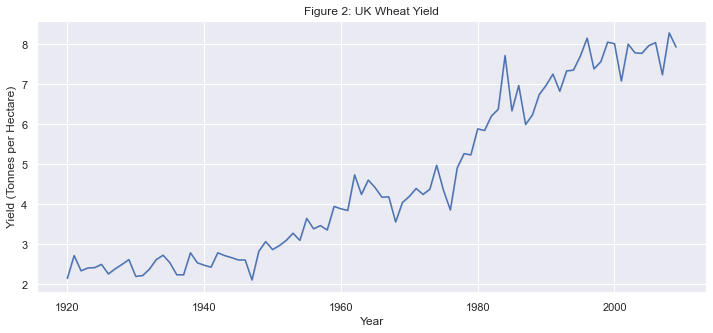

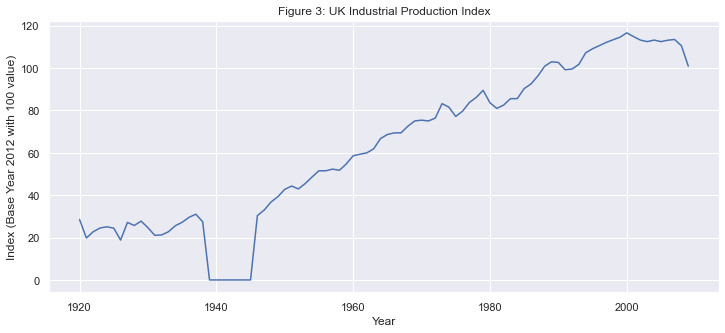

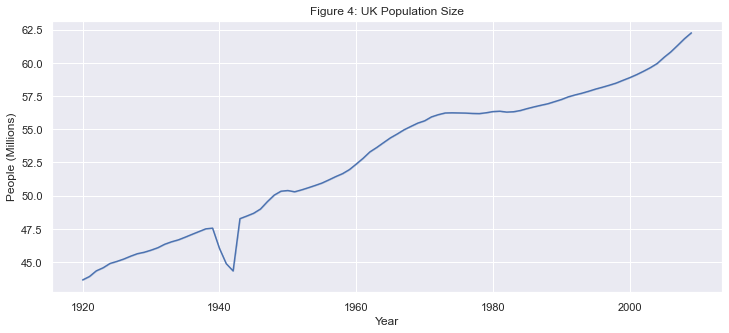

In [13]:
# Import Libraries
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize': (12,5)}, style="darkgrid")
sns.lineplot(x='Year', y='Wheat Yield', data=drought_df)
plt.title('Figure 2: UK Wheat Yield')
plt.ylabel('Yield (Tonnes per Hectare)')
plt.show()

sns.set(rc={'figure.figsize': (12,5)}, style="darkgrid")
sns.lineplot(x='Year', y='Industry Output', data=drought_df, err_style=None)
plt.title('Figure 3: UK Industrial Production Index')
plt.ylabel('Index (Base Year 2012 with 100 value)')
plt.show()

sns.set(rc={'figure.figsize': (12,5)}, style="darkgrid")
sns.lineplot(x=drought_df['Year'], y=drought_df['Population']/1e6)
plt.title('Figure 4: UK Population Size')
plt.ylabel('People (Millions)')
plt.show()

We can see that all three demand-side factors increase over time. Over the course of nine decades, the UK population increased by roughly 50%, while the agricultural and industrial indicators increased roughly four-fold over the same period. There was much more fluctuation in their increase especially with wheat yields, compared to the steady increase in population. The impact of World War II is obvious in the second two graphs. The sharp fall in population is understandable, but the fall of the industrial index to zero may not be completely realistic. Presumably a purposeful decision by the economists who made the index, it is important for us to note that this property of the data is not helpful for our study. This is because while traditional manufacturing was disrupted, [resources were diverted to producing ammunition and aircraft for the war effort](https://en.wikipedia.org/wiki/United_Kingdom_home_front_during_World_War_II#Industry), and therefore the water consumption from factories and industrial processes certainly did not disappear. Later on, we will replace the index values in this period using linear interpolation between the two non-zero indices at the war's beginning and end, so that the true historical story is accurately reflected in the data, and the models we produce.

### Climatic Features

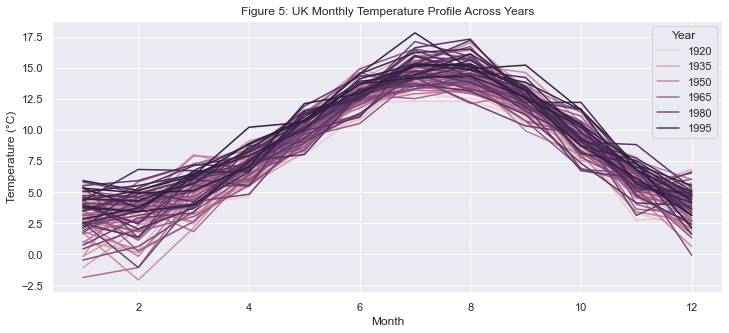

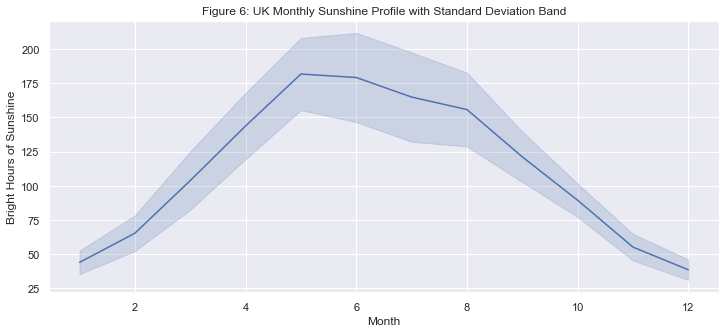

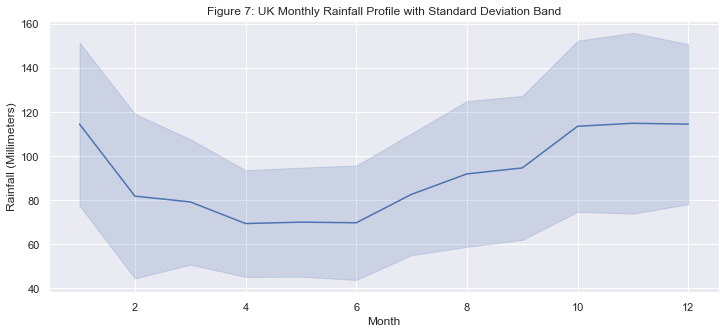

In [14]:
sns.set(rc={'figure.figsize': (12,5)}, style="darkgrid")
sns.lineplot(x='Month', y='Temperature', hue='Year', data=drought_df)
plt.title('Figure 5: UK Monthly Temperature Profile Across Years')
plt.ylabel('Temperature (°C)')
plt.show()

sns.set(rc={'figure.figsize': (12,5)}, style="darkgrid")
sns.lineplot(x='Month', y='Sunshine', data=drought_df, ci='sd')
plt.title('Figure 6: UK Monthly Sunshine Profile with Standard Deviation Band')
plt.ylabel('Bright Hours of Sunshine')
plt.show()

sns.set(rc={'figure.figsize': (12,5)}, style="darkgrid")
sns.lineplot(x='Month', y='Rainfall', data=drought_df, ci='sd')
plt.title('Figure 7: UK Monthly Rainfall Profile with Standard Deviation Band')
plt.ylabel('Rainfall (Millimeters)')
plt.show()

All three climate indicators show fairly similar annual seasonality. By plotting the temperature as we have done above, slicing the dataset across the years using the color gradient, we can see this seasonality as well as year-on-year increases across all months due to climate change. Notably patterns in rainfall over the course of each year are the least reliable, as shown by the wide error band throughout the plot.

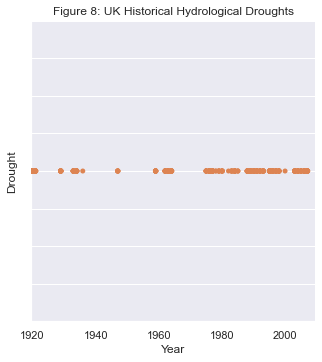

Percentage of years spent in drought: 33.6 %.


In [15]:
sns.set(rc={'figure.figsize': (20,20)}, style="darkgrid")
droughtplot = sns.catplot(x='Year', y='Drought', hue='Drought', data=drought_df, legend=False)
droughtplot.set(xticks=[0,20,40,60,80], ylim=(0.9,1.1), yticklabels=[])
plt.title('Figure 8: UK Historical Hydrological Droughts')
plt.show()
print('Percentage of years spent in drought:', round(np.mean(drought_df['Drought'])*100, 1),'%.')

Finally we plot a timeline of DWS events. We can see that there are DWS across the entirety of the time period we are studying, but clearly their frequency is increasing each year.

## Feature Engineering and Selection

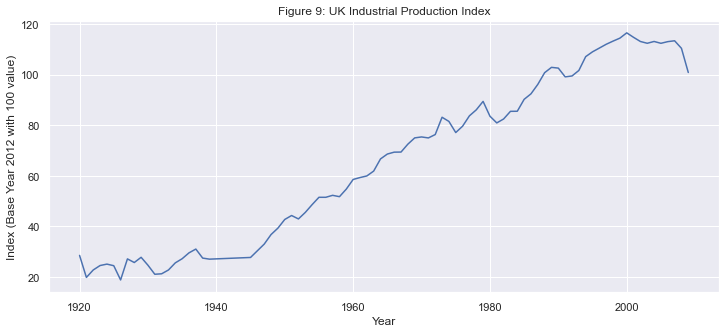

In [16]:
# Interpolation for the WWII period in the IPI Data.
interpol_a = float(drought_df['Industry Output'][(drought_df['Year']==1938) & (drought_df['Month']==12)])
interpol_b = float(drought_df['Industry Output'][(drought_df['Year']==1946) & (drought_df['Month']==1)])
num_months = 85
start_index = int(drought_df[(drought_df['Year']==1938) & (drought_df['Month']==12)].index[0])
for i in range(num_months):
    drought_df.iloc[start_index+i,3] = interpol_a*(num_months-i)/num_months + interpol_b*i/num_months
    
sns.set(rc={'figure.figsize': (12,5)}, style="darkgrid")
sns.lineplot(x='Year', y='Industry Output', data=drought_df, err_style=None)
plt.title('Figure 9: UK Industrial Production Index')
plt.ylabel('Index (Base Year 2012 with 100 value)')
plt.show()

This plot shows the result of the imputation of zero values for the industrial output index, during the WWII period.

In [17]:
# Feature Selection
drought_df_model = drought_df.drop(['Year','Month'], axis=1)
X = np.array(drought_df_model.iloc[:,:-1])
y = np.array(drought_df_model.iloc[:,-1])
X.shape, y.shape

((1080, 6), (1080,))

We will not use the month or year columns as feature variables in our models.

## Model Building

We approach the data as a binary classification problem, producing models which output the probability of a DWS event in a particular month based on the six feature variables. It is worth bearing in mind that the modal target class ('no drought') makes up about 66.4% of the data, and therefore 0.664 is a good benchmark accuracy. If some sophisticated model cannot exceed this accuracy then it is not worth the computing resources used to construct it. Below we implement three model architectures: K-nearest neighbours, logistic regression and decision tree.

In [18]:
# Import libraries
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [19]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [20]:
# Construct knn regression pipeline
scaler_knn = MinMaxScaler()
model_knn = KNeighborsClassifier()
pipeline_knn = Pipeline([('scaler', scaler_knn),
                        ('knn', model_knn)])

# Hyperparameter Tuning
params_knn = {'knn__n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
gscv_knn = GridSearchCV(pipeline_knn, param_grid=params_knn, scoring='accuracy', cv=5)
gscv_knn.fit(X_train, y_train)
gscv_knn_results = pd.DataFrame(gscv_knn.cv_results_)[['mean_fit_time', 'param_knn__n_neighbors', 'mean_test_score',
                                   'std_test_score', 'rank_test_score']]
gscv_knn_results.style.set_caption('Figure 10: K-Nearest Neighbours Hyperparameter Tuning')

,mean_fit_time,param_knn__n_neighbors,mean_test_score,std_test_score,rank_test_score
0,0.002241,1,0.691020,0.024428,10
1,0.001133,2,0.707199,0.022431,9
2,0.000567,3,0.729177,0.013658,5
3,0.000000,4,0.726852,0.016902,6
4,0.004119,5,0.725709,0.027357,7
5,0.000594,6,0.725696,0.016561,8
6,0.000000,7,0.733822,0.024263,3
7,0.000000,8,0.732679,0.022530,4
8,0.000000,9,0.747701,0.018280,1
9,0.000000,10,0.740765,0.012407,2


In [36]:
# Construct logistic regression pipeline
scaler_lr = MinMaxScaler()
model_lr = LogisticRegression(solver='liblinear')
pipeline_lr = Pipeline([('scaler', scaler_lr),
                        ('lr', model_lr)])

# Hyperparameter Tuning
params_lr = {'lr__C': [100,10,1,0.1,0.01], 'lr__penalty': ['l1','l2']}
gscv_lr = GridSearchCV(pipeline_lr, param_grid=params_lr, scoring='accuracy', cv=5)
gscv_lr.fit(X_train, y_train)
gscv_lr_results = pd.DataFrame(gscv_lr.cv_results_)[['mean_fit_time', 'param_lr__C', 'param_lr__penalty', 'mean_test_score',
                                   'std_test_score', 'rank_test_score']]
gscv_lr_results.style.set_caption('Figure 11: Logistic Regression Hyperparameter Tuning')

,mean_fit_time,param_lr__C,param_lr__penalty,mean_test_score,std_test_score,rank_test_score
0,0.016164,100,l1,0.748851,0.015631,1
1,0.000203,100,l2,0.748851,0.015631,1
2,0.018889,10,l1,0.747695,0.017238,3
3,0.000000,10,l2,0.745376,0.017059,4
4,0.006251,1,l1,0.736120,0.019420,6
5,0.003150,1,l2,0.739595,0.013933,5
6,0.006278,0.100000,l1,0.730327,0.011828,7
7,0.002618,0.100000,l2,0.725696,0.015302,8
8,0.000993,0.010000,l1,0.660882,0.002434,9
9,0.003134,0.010000,l2,0.660882,0.002434,9


In [22]:
# Construct decision tree pipeline
scaler_dt = MinMaxScaler()
model_dt = DecisionTreeClassifier()
pipeline_dt = Pipeline([('scaler', scaler_dt),
                        ('dt', model_dt)])

# Hyperparameter tuning
params_dt = {'dt__max_depth': [1,2,3,4,5,6,7,8,9,10]}
gscv_dt = GridSearchCV(pipeline_dt, param_grid=params_dt, scoring='accuracy', cv=5)
gscv_dt.fit(X_train, y_train)
gscv_dt_results = pd.DataFrame(gscv_dt.cv_results_)[['mean_fit_time', 'param_dt__max_depth',
                                   'mean_test_score', 'std_test_score', 'rank_test_score']]
gscv_dt_results.style.set_caption('Figure 12: Decision Tree Hyperparameter Tuning')

,mean_fit_time,param_dt__max_depth,mean_test_score,std_test_score,rank_test_score
0,0.002552,1,0.725729,0.025929,10
1,0.001794,2,0.755821,0.018748,9
2,0.002608,3,0.795161,0.011550,8
3,0.003126,4,0.855370,0.026177,7
4,0.003385,5,0.872732,0.024082,6
5,0.003135,6,0.892385,0.016868,5
6,0.000000,7,0.901674,0.029831,4
7,0.000000,8,0.910922,0.035116,3
8,0.000000,9,0.928256,0.026479,2
9,0.003239,10,0.930575,0.019291,1


In [23]:
# Confirm the results of the cross-validations using the test set.
print("Best KNN model has test accuracy: {:.3f}".format(gscv_knn.score(X_test, y_test)))
print("Best logistic regressor has test accuracy: {:.3f}".format(gscv_lr.score(X_test, y_test)))
print("Best decision tree has test accuracy: {:.3f}".format(gscv_dt.score(X_test, y_test)))

Best KNN model has test accuracy: 0.731
Best logistic regressor has test accuracy: 0.731
Best decision tree has test accuracy: 0.963


We can see clearly that the decision tree model is more accurate than the other two. The accuracy of the decision tree improves steadily with the `max_depth` parameter, and we fine-tune this parameter below.

The next block of code allows us to see how the model's prediction varies with respect to two of the feature variables, while the rest of the features are held at some fixed values.

In [24]:
def drought_prediction_vals(clf_pipeline, indep_vars, fixed_vals=None):
    # Construct input array and contour space
    x_ind = list(drought_df_model.columns).index(indep_vars[0])
    y_ind = list(drought_df_model.columns).index(indep_vars[1])
    x_vals = np.linspace(np.min(drought_df_model[indep_vars[0]]), np.max(drought_df_model[indep_vars[0]]), 101)
    y_vals = np.linspace(np.min(drought_df_model[indep_vars[1]]), np.max(drought_df_model[indep_vars[1]]), 101)
    mesh = np.meshgrid(x_vals, y_vals)
    
    # All bar two of the feature variables are held constant (their respective means by default).
    if fixed_vals == None:
        grid_vals = np.array(list(np.mean(X, axis=0))*10201).reshape(101,101,-1)
    else:
        grid_vals = np.array(fixed_vals*10201).reshape(101,101,-1)
    grid_vals[:,:,x_ind] = mesh[0]
    grid_vals[:,:,y_ind] = mesh[1]
    
    # Evaluate model's predictions
    z_vals = np.array([[clf_pipeline.predict_proba(arr.reshape(1,-1))[0][1] for arr in grid_vals[i,:]] for i in range(101)])
    return [x_vals, y_vals, z_vals]

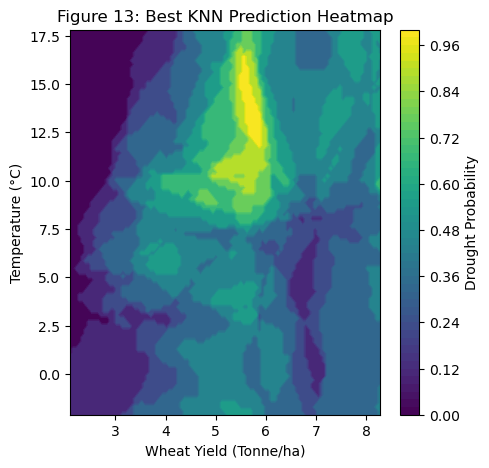

In [38]:
plotdata = drought_prediction_vals(gscv_knn.best_estimator_, ['Wheat Yield','Temperature'])
plt.figure(figsize=(5,5))
plt.style.use('default')
plt.contourf(plotdata[0], plotdata[1], plotdata[2], 50, cmap='viridis')
plt.colorbar(label='Drought Probability')
plt.title('Figure 13: Best KNN Prediction Heatmap')
plt.xlabel('Wheat Yield (Tonne/ha)')
plt.ylabel('Temperature (°C)')
plt.show()

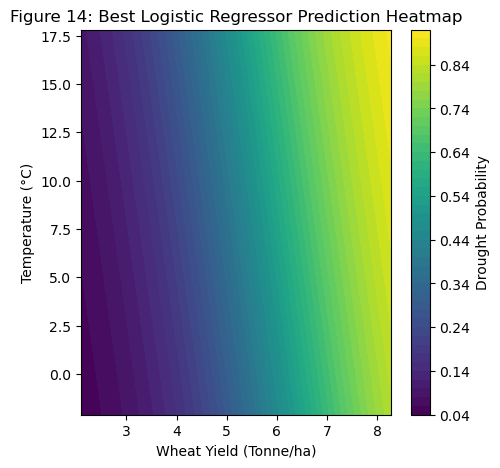

In [39]:
plotdata = drought_prediction_vals(gscv_lr.best_estimator_, ['Wheat Yield','Temperature'])
plt.figure(figsize=(5,5))
plt.style.use('default')
plt.contourf(plotdata[0], plotdata[1], plotdata[2], 50, cmap='viridis')
plt.colorbar(label='Drought Probability')
plt.title('Figure 14: Best Logistic Regressor Prediction Heatmap')
plt.xlabel('Wheat Yield (Tonne/ha)')
plt.ylabel('Temperature (°C)')
plt.show()

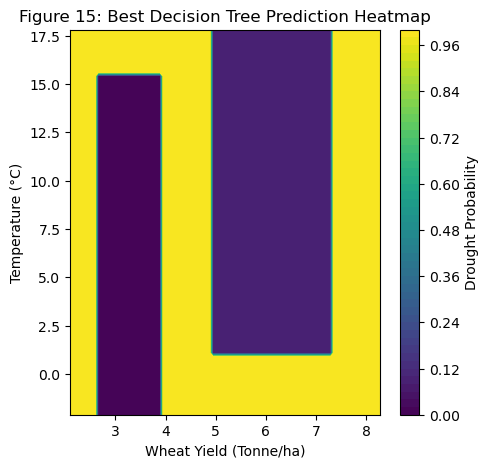

In [40]:
plotdata = drought_prediction_vals(gscv_dt.best_estimator_, ['Wheat Yield','Temperature'])
plt.figure(figsize=(5,5))
plt.style.use('default')
plt.contourf(plotdata[0], plotdata[1], plotdata[2], 50, cmap='viridis')
plt.colorbar(label='Drought Probability')
plt.title('Figure 15: Best Decision Tree Prediction Heatmap')
plt.xlabel('Wheat Yield (Tonne/ha)')
plt.ylabel('Temperature (°C)')
plt.show()

In [28]:
print("Feature:            Logistic Regression Coefficient:\n"+"-"*50)
for i, var in enumerate(drought_df_model.columns[:-1]):
    print("{:<20}{:.2f}".format(var,gscv_lr.best_estimator_.steps[1][1].coef_[0,i]))

Feature:            Logistic Regression Coefficient:
--------------------------------------------------
Wheat Yield         4.53
Industry Output     2.65
Population          -5.37
Temperature         0.78
Sunshine            -0.84
Rainfall            -1.38


These visualisations help give a more rounded comparison of the two models. In particular, we see that while the decision tree may have a greater accuracy, it may sacrifice some level of interpretability in the process. Meanwhile, the logistic regressor's prediction can easily be understood: "higher temperatures and agricultural outputs both contribute to greate probability of drought, but wheat yield is a more significant factor". In addition, the coefficients displayed above contribute even further to this aspect of the logistic regression. On the other hand the K-nearest neighbours approach seems to be the least interpretable and the least accurate.

Since the entirety of the dataset is quite limited, perhaps the complex decision tree is overfitting as well. Some evidence for this is the confusing strip of high probability in the first plot - why would wheat yields in the 4 to 5 tonne/ha range correlate with higher drought probability? Inspecting the data exploration from earlier (Fig. 2, 8), we can see that during the 1970s, the UK wheat yields were consistently in this range, and this was accompanied by extensive hydrological droughts in that decade.

But inspecting the grid-search tables, we can see that the decision tree model outperforms the logistic regressor even when `max_depth` is low. So perhaps we can use this to build a less complex decision tree model as a compromise.

In [29]:
scaler_dt2 = MinMaxScaler()
model_dt2 = DecisionTreeClassifier(max_depth=4)
pipeline_dt2 = Pipeline(steps=[('scaler', scaler_dt2),
                               ('dt', model_dt2)])
pipeline_dt2.fit(X_train, y_train)
print("Decision tree model with max. depth 4 has train accuracy: {:.3f}".format(pipeline_dt2.score(X_train, y_train)))
print("Decision tree model with max. depth 4 has test accuracy: {:.3f}".format(pipeline_dt2.score(X_test, y_test)))

Decision tree model with max. depth 4 has train accuracy: 0.826
Decision tree model with max. depth 4 has test accuracy: 0.806


### Simple Decision Tree Prediction Heatmaps
This model only depends on the wheat yield, population, and temperature features. In the plot below wheat yield and temperature vary, while the population (and all other features) are fixed at their mean values within the data, i.e. 53 million for population. Therefore it is comparable to the two previous heatmaps for the other models.

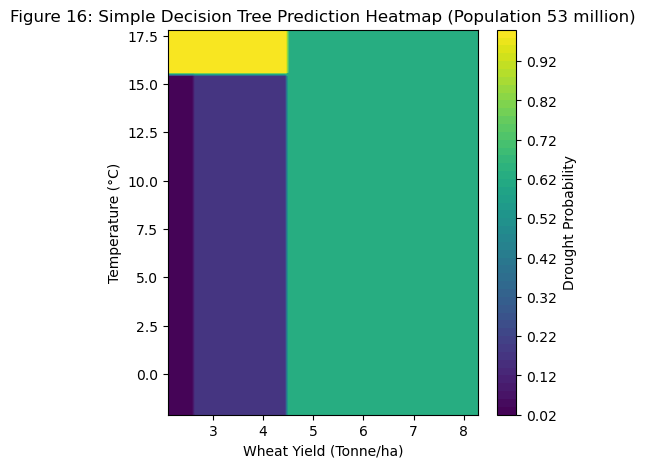

In [30]:
plotdata = drought_prediction_vals(pipeline_dt2, ['Wheat Yield','Temperature'], fixed_vals=[4.57, 650, 5.28e7, 8.50, 112, 9.13])
plt.figure(figsize=(5,5))
plt.style.use('default')
plt.contourf(plotdata[0], plotdata[1], plotdata[2], 50, cmap='viridis')
plt.colorbar(label='Drought Probability')
plt.title('Figure 16: Simple Decision Tree Prediction Heatmap (Population 53 million)')
plt.xlabel('Wheat Yield (Tonne/ha)')
plt.ylabel('Temperature (°C)')
plt.show()

Below we plot further visuals exploring how the model's prediction varies with population and temperature, while wheat yields are fixed at some stated value.

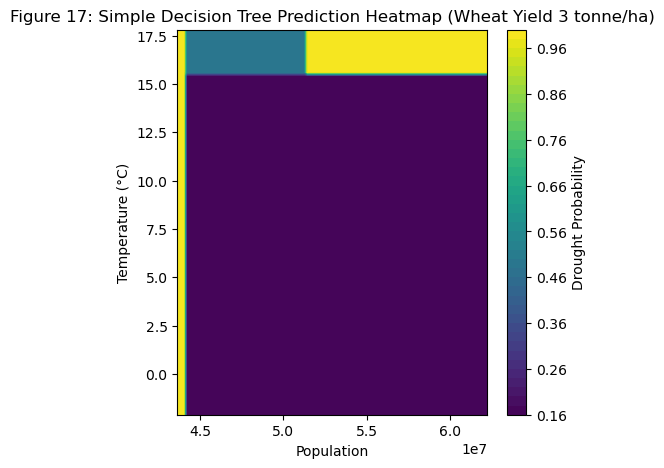

In [31]:
plotdata = drought_prediction_vals(pipeline_dt2, ['Population','Temperature'], fixed_vals=[3, 650, 5.28e7, 8.50, 112, 9.13])
plt.figure(figsize=(5,5))
plt.style.use('default')
plt.contourf(plotdata[0], plotdata[1], plotdata[2], 50, cmap='viridis')
plt.colorbar(label='Drought Probability')
plt.title('Figure 17: Simple Decision Tree Prediction Heatmap (Wheat Yield 3 tonne/ha)')
plt.xlabel('Population')
plt.ylabel('Temperature (°C)')
plt.show()

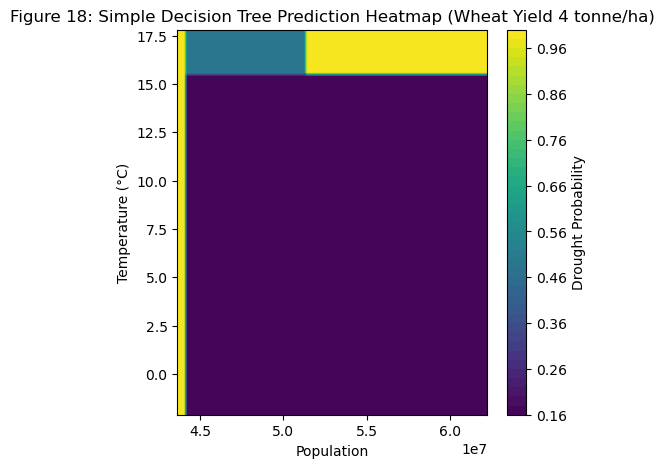

In [32]:
plotdata = drought_prediction_vals(pipeline_dt2, ['Population','Temperature'], fixed_vals=[4, 650, 5.28e7, 8.50, 112, 9.13])
plt.figure(figsize=(5,5))
plt.style.use('default')
plt.contourf(plotdata[0], plotdata[1], plotdata[2], 50, cmap='viridis')
plt.colorbar(label='Drought Probability')
plt.title('Figure 18: Simple Decision Tree Prediction Heatmap (Wheat Yield 4 tonne/ha)')
plt.xlabel('Population')
plt.ylabel('Temperature (°C)')
plt.show()

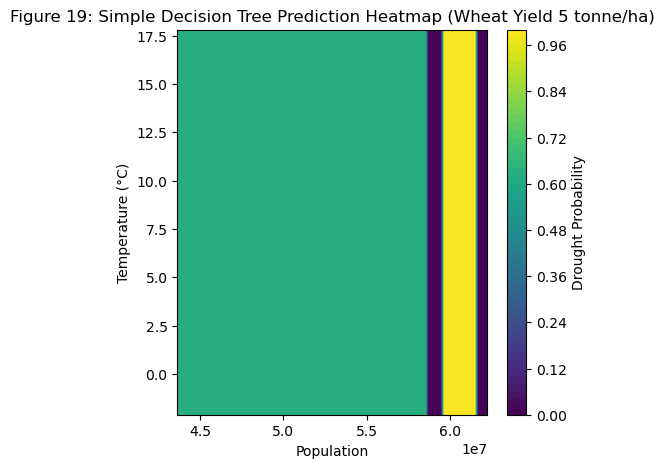

In [33]:
plotdata = drought_prediction_vals(pipeline_dt2, ['Population','Temperature'], fixed_vals=[5, 650, 5.28e7, 8.50, 112, 9.13])
plt.figure(figsize=(5,5))
plt.style.use('default')
plt.contourf(plotdata[0], plotdata[1], plotdata[2], 50, cmap='viridis')
plt.colorbar(label='Drought Probability')
plt.title('Figure 19: Simple Decision Tree Prediction Heatmap (Wheat Yield 5 tonne/ha)')
plt.xlabel('Population')
plt.ylabel('Temperature (°C)')
plt.show()

This model seems to be much more suitable. It's test accuracy still exceeds 80%, but it's prediction appears to be much more interpretable, at least based on the plots above.

## Conclusion

The second decision tree seems to be an acceptable statistical model to report the probability of a drought/water security (DWS) event. Its accuracy, even on the test dataset, was 81%, comfortably exceeding the 66% benchmark. Combined with the fact that the prediction boundaries it produces are understandable, this model could serve to deliver some very basic insights on the relationship between the economy, the climate, and water security in the UK. For instance, it highlights population, temperature, and wheat yields as the most important factors from our collected data. If we compare the first plot for the simple decision tree with the equivalent plot for the logistic regressor (Fig. 14, 16), we can make a similar heuristic interpretation as before: "ceteris paribus, there is more than a 50% chance of drought if average temperatures or wheat yields exceed certain threshold values (which depend on the other fixed variables)". We have also included considerations outside of the raw data, for instance the imputation of industry output values during the WWII period, and selecting a range of features which encode information about the state of water consumption as well as climate. This can help us to be confident that the model is realistic rather than just inferring causation from correlation, and also helped us identify overfitting in the early deep decision tree model.

However, there are obvious limitations to the whole study. The data is very limited and in the real-world, policy makers would have to consider a much larger body of data together with expert domain knowledge in history, economics, climate science, and water infrastructure in order to draw more reliable, and actionable conclusions. The data is also inherently problematic in places - particularly the wheat yield data. This was actually the hardest data to source online in the first place, but it has two flaws. Firstly, it is really a measure of productivity rather than total activity, which would better encode information about national water consumption from agriculture. Secondly, it potentially leaks information about the target variable into the feature data, because of course years in which a drought occurred would report lower crop yields. To prevent this I removed the month and year columns from the model data - in this way, the model couldn't infer a drought from the fact that crop yields were low compared to the given year (recall from Fig. 2 that the overall trend in yields was a clear increase across the years, with short-term fluctuations). Another issue with the data is that the feature variables on the demand-side are highly correlated, which makes the feature space even more limited. It would be preferable to replace the wheat yield data with, say, the total UK arable land over the years, but this data is difficult to find for such a long time period.

In this sense, the project meets the first two objectives set out at the start, but fails to achieve the third. We have successfully explored the data used in the scope of the project and built an intelligible, reasonable model which performs statistically to estimate the probability of a DWS event given certain national circumstances. Therefore, the project hopefully acts as a demonstration of how data science can be helpful in approaching the daunting task of investigating the impact of a changing climate, as well as other factors, has on UK water security at a national level.

This project was a great chance for me to develop python skills in some of the core data science libraries. It was challenging to combine all of the raw data given the differing file types, and arrangements of the datasets with respect to their date labels, but implementing solutions with the `datetime` library allowed me to bypass some difficulties there. It gave me some more experience creating visualisations: the `seaborn` library allowed me to create sleek and nuanced exploratory visuals, and coding the `drought_prediction_plot` function to plot the probability heatmaps at the end was also an interesting challenge. Finally I was able to implement machine learning pipelines with `sklearn` which helped streamline the hyperparameter search and cross-validation process.

If you have any questions regarding the data I used, or any suggestions as to how I could improve the project please contact me, I would be delighted to hear your thoughts.